In [29]:
import nbimporter
import Generalized_Galton_Board # This imports from Generalized_Galton_Board.ipynb
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import HGate, RYGate, RXGate, XGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import *
from qiskit_ibm_transpiler.ai.routing import AIRouting

## Setting Up Noisy Backend Simulators

This section implements realistic noise models by creating simulators that replicate the error characteristics and physical constraints of actual IBM quantum processors. We analyze how hardware limitations affect the Quantum Galton Board (QGB) algorithm performance compared to the idealized noiseless simulations from `Generalized_Galton_Board.ipynb`.

Real quantum devices impose fundamental constraints that significantly affect algorithm execution:

- **Number of qubits**: Total physical qubits available on the quantum processor
- **Coupling map**: Graph showing which qubits can directly interact (perform two-qubit gates)
- **Readout error**: Probability of measurement errors when reading qubit states
- **Basis gates**: Native gate set that the hardware can execute directly 
- **Gate fidelities**: Imperfect gate operations introducing computational errors

To execute circuits on realistic hardware, we employ Qiskit's **Pass Manager** for automated circuit optimization and hardware mapping (logical to physical qubits):

- **optimization_level=3**: Highest optimization level that performs aggressive circuit simplification, gate reduction, and routing optimization
- **seed_transpiler**: Ensures reproducible results by fixing the randomness in optimization algorithms
- The pass manager handles gate decomposition, qubit mapping, and circuit optimization automatically

This realistic simulation framework enables quantitative analysis of how quantum noise degrades the QGB's statistical properties.

In [4]:
service = QiskitRuntimeService(name= 'general-use') # please save your details first, and change the instance name accordingly
# service.saved_accounts()
seed= 42

real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_torino"),
]

noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

# Taking the ibm_torino as an example
properties = noisy_fake_backends[1].properties()
print(f"Properties of the backend {noisy_fake_backends[1].name}:")
print(f"Number of qubits: {noisy_fake_backends[1].num_qubits}")
print(f"Coupling map: {noisy_fake_backends[1].coupling_map}")
print(f"Readout error: {properties.readout_error(1)}")
print(noisy_fake_backends[1].configuration().basis_gates)

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]
The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['x', 'measure', 'sx', 'reset', 'id', 'ecr']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['x', 'measure', 'cz', 'reset', 'sx', 'id']>)]
Properties of the backend aer_simulator_from(ibm_torino):
Number of qubits: 133
Coupling map: [[0, 1], [0, 15], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 16], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 17], [9, 8], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [12, 18], [13, 12], [13, 14], [14, 13], [15, 0], [15, 19], [16, 4], [16, 23], [17, 8], [17, 27], [18, 12], [18, 31], [19, 15], [19, 20], [20, 19], [20, 21], [21, 20], [21, 22], [21, 34], [22, 21], [22, 23], [23, 16], [23, 22], [23, 24], [24, 23], [24, 25], [25, 24], [

### Circuit Error Analysis and Characterization Functions

In [30]:
def circuit_error_analysis(backend, circuit: QuantumCircuit, n: int) -> dict:
    """
    Comprehensive error analysis for a transpiled quantum circuit.
    
    Args:
        backend: Quantum backend with properties
        circuit: Transpiled quantum circuit
        n: Number of levels in Galton board (for readout error calculation)
    
    Returns:
        dict: Complete error analysis including totals, breakdowns, and pair details
    """
    properties = backend.properties()
    
    acc_single_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    pair_dict = {}  
    
    basis_gates = backend.configuration().basis_gates
    two_qubit_gate = "ecr" if "ecr" in basis_gates else "cz"
    
    # Process all instructions in one pass
    for instruction in circuit.data:
        num_qubits = instruction.operation.num_qubits
        operation_name = instruction.operation.name
        
        if num_qubits == 1 and operation_name not in ['measure', 'reset']:
            # Single-qubit gate processing
            try:
                qubits = [circuit.qubits.index(q) for q in instruction.qubits]
                acc_single_qubit_error += properties.gate_error(gate=operation_name, qubits=qubits)
                single_qubit_gate_count += 1
            except (ValueError, KeyError):
                # Skip if gate error data not available for this qubit
                single_qubit_gate_count += 1
                
        elif num_qubits == 2:
            # Two-qubit gate processing
            two_qubit_gate_count += 1
            pair = tuple(sorted([instruction.qubits[0]._index, instruction.qubits[1]._index]))
            
            try:
                error = properties.gate_error(gate=two_qubit_gate, qubits=list(pair))
                
                if pair in pair_dict:
                    pair_dict[pair]['accumulated_error'] += error
                    pair_dict[pair]['count'] += 1
                else:
                    pair_dict[pair] = {
                        'single_error': error,
                        'accumulated_error': error,
                        'count': 1
                    }
            except (ValueError, KeyError):
                # Skip if gate error data not available for this qubit pair
                # This can happen when qubits are not connected or error data is missing
                # print(f"Warning: Could not find error data for {two_qubit_gate} gate on qubits {pair}")
                if pair not in pair_dict:
                    pair_dict[pair] = {
                        'single_error': 0.0,
                        'accumulated_error': 0.0,
                        'count': 1
                    }
                else:
                    pair_dict[pair]['count'] += 1
    
    # Calculate readout errors with error handling
    try:
        qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:2*n + 1]
        acc_readout_error = 0
        for q in qubit_layout:
            try:
                acc_readout_error += properties.readout_error(q)
            except (ValueError, KeyError):
                # print(f"Warning: Could not find readout error for qubit {q}")
                pass
    except (AttributeError, KeyError):
        # print("Warning: Could not access qubit layout, setting readout error to 0")
        acc_readout_error = 0
    
    # Calculate totals
    acc_two_qubit_error = sum(pair_data['accumulated_error'] for pair_data in pair_dict.values())
    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    
    # Prepare pair analysis data
    pair_list = list(pair_dict.keys())
    error_pair_list = [pair_dict[pair]['single_error'] for pair in pair_list]
    error_acc_pair_list = [pair_dict[pair]['accumulated_error'] for pair in pair_list]
    
    return {
        # Detailed error breakdown
        'errors': {
            'total': acc_total_error,
            'two_qubit': acc_two_qubit_error,
            'single_qubit': acc_single_qubit_error,
            'readout': acc_readout_error
        },
        
        # Gate counts
        'gate_counts': {
            'single_qubit': single_qubit_gate_count,
            'two_qubit': two_qubit_gate_count
        },
        
        # Two-qubit pair analysis
        'pair_analysis': {
            'pairs': pair_list,
            'single_errors': error_pair_list,
            'accumulated_errors': error_acc_pair_list,
            'pair_details': pair_dict
        }
    }


### Functions for post processing and comparing distributions

In [31]:
def counts_to_probabilities(counts):
    total_shots = sum(counts.values())
    return {state: count / total_shots for state, count in counts.items()}


def filter_counts_by_hamming_weight(counts: dict) -> dict:
    """
    Filters a dictionary of measurement counts, keeping only the outcomes
    that have a Hamming weight of 1.

    Args:
        counts (dict): The dictionary of measurement outcomes and their counts.
                       The keys are binary strings (e.g., '0100').

    Returns:
        dict: A new dictionary with only the filtered counts.
    """
    filtered_counts = {}
    for outcome, count in counts.items():
        if outcome.count('1') == 1:
            filtered_counts[outcome] = count
    return filtered_counts

def total_variation_distance(p_dist, q_dist):
    """Computes the Total Variation Distance between two distributions."""
    states = set(p_dist.keys()) | set(q_dist.keys())
    tvd = 0.5 * sum(abs(p_dist.get(state, 0) - q_dist.get(state, 0)) for state in states)
    return tvd

def kullback_leibler_divergence(p_dist, q_dist):
    """Computes the KL divergence of P from Q. Assumes P is the noisy distribution."""
    states = set(p_dist.keys()) | set(q_dist.keys())
    kl_div = 0
    for state in states:
        p_prob = p_dist.get(state, 0)
        q_prob = q_dist.get(state, 0)
        # Avoid log(0)
        if p_prob > 0 and q_prob > 0:
            kl_div += p_prob * np.log(p_prob / q_prob)
    return kl_div


def compare_distributions(noisy_counts, noiseless_counts, n, 
                         filter_hamming=False, 
                         title_prefix="", 
                         figsize=(8, 5),
                         show_metrics=True,
                         return_metrics=False):
    """
    Generalized function to compare noisy and noiseless quantum distributions.
    
    Args:
        noisy_counts (dict): Counts from noisy simulation
        noiseless_counts (dict): Counts from noiseless simulation  
        n (int): Number of levels in Galton board
        filter_hamming (bool): Whether to filter by Hamming weight = 1
        title_prefix (str): Prefix for the plot title
        figsize (tuple): Figure size for the plot
        show_metrics (bool): Whether to print distance metrics
        return_metrics (bool): Whether to return metrics as dict
        
    Returns:
        dict (optional): Dictionary containing TVD and KL divergence if return_metrics=True
    """
    
    # Apply Hamming weight filter if requested
    if filter_hamming:
        noisy_counts = filter_counts_by_hamming_weight(noisy_counts)
        filter_text = " (Filtered)"
    else:
        filter_text = ""
    
    # Convert to probabilities
    p_noisy = counts_to_probabilities(noisy_counts)
    p_noiseless = counts_to_probabilities(noiseless_counts)
    
    # Create comparison plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get all unique states and their probabilities
    all_states = sorted(list(set(p_noisy.keys()) | set(p_noiseless.keys())))
    x_ticks = np.arange(len(all_states))
    width = 0.35  # The width of the bars
    
    noisy_probs = [p_noisy.get(state, 0) for state in all_states]
    noiseless_probs = [p_noiseless.get(state, 0) for state in all_states]
    
    # Plot the bars side-by-side
    ax.bar(x_ticks - width/2, noiseless_probs, width, label='Noiseless', color='royalblue')
    ax.bar(x_ticks + width/2, noisy_probs, width, label=f'Noisy{filter_text}', color='salmon')
    
    # Set labels and title
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(all_states, rotation=90)
    ax.set_xlabel("Measured States")
    ax.set_ylabel("Probability")
    
    # Construct title
    if title_prefix:
        title = f"{title_prefix} (n={n})"
    else:
        title = f"Comparison of Noisy and Noiseless Distributions (n={n})"
    ax.set_title(title)
    
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display/return metrics
    tvd = total_variation_distance(p_noisy, p_noiseless)
    kl_div = kullback_leibler_divergence(p_noisy, p_noiseless)
    
    if show_metrics:
        print(f"Total Variation Distance (TVD): {tvd:.4f}")
        print(f"Kullback-Leibler Divergence (KL): {kl_div:.4f}")
    
    if return_metrics:
        return {
            'tvd': tvd,
            'kl_divergence': kl_div,
            'noisy_probabilities': p_noisy,
            'noiseless_probabilities': p_noiseless
        }


## 3-Level QGB: Noisy Hardware Simulation

As an example we demonstrate a $3$ level QGB on a noisy simulator.

In [33]:
n=3 # number of levels in the Galton board
qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
backend= AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)
qubit_layout = list(qc_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 
print(f"Qubit layout: {qubit_layout}")

print('Gates used on the noisy simulator:', qc_transpiled.count_ops()) 

Qubit layout: [67, 66, 68, 74, 65, 69, 55]
Gates used on the noisy simulator: OrderedDict([('sx', 328), ('rz', 231), ('cz', 170), ('x', 6), ('measure', 4), ('reset', 3)])


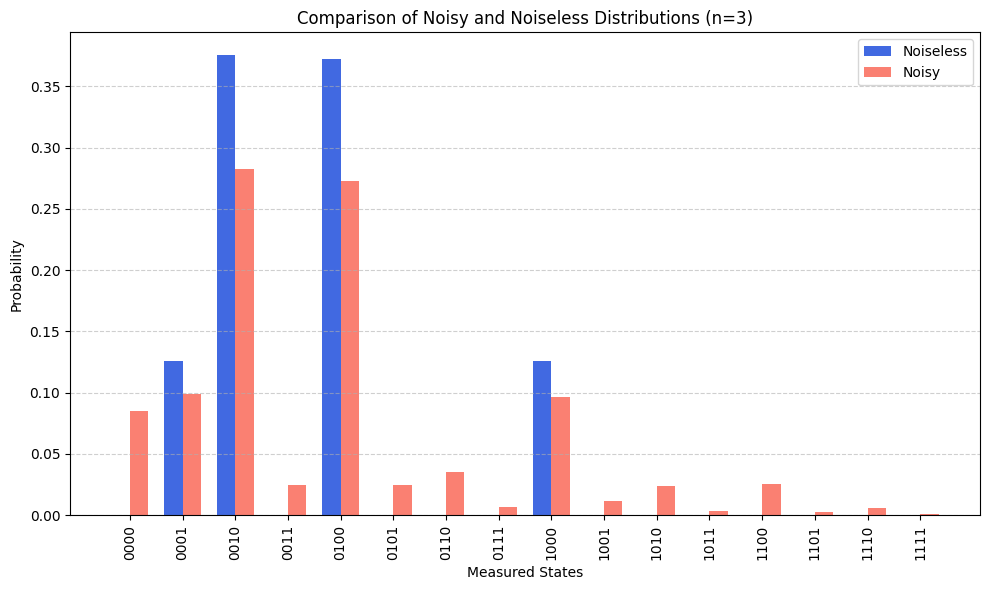

In [34]:
# Run noisy simulation
job = backend.run(qc_transpiled, shots=100000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()

# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=100000)  # Using same shot count for fair comparison
noiseless_counts = job.result().get_counts()

# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=False, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=False,
                      return_metrics=False)


#### The noisy simulation results show additional measurement outcomes not present in the ideal case. 

Since the theoretical Quantum Galton Board produces measurement outcomes with exactly one '1' and the remaining bits as '0' (i.e., bitstrings with Hamming weight 1), we can filter out noise-induced erroneous samples by retaining only these valid outcomes. This can be achieved by setting the `filter_hamming` parameter of the `compare_distributions` to True. The valid outcomes would be used to obtain the final desired distribution which is compared against the noiseless distribution via the Kullback Leibler Divergence and Total variation distance metrics. This comparison is achieived by setting the `show_metrics` parameter to True.

**Note:**

- Kullback-Leibler divergence quantifies how one probability distribution diverges from another, often considered a reference. It is a non-symmetric measure where a value of zero indicates that the distributions are identical.

- Total Variation Distance measures the maximum absolute difference between the probabilities of any event in two distributions. It is a true metric with a value ranging from 0 (identical distributions) to 1 (maximally different distributions).

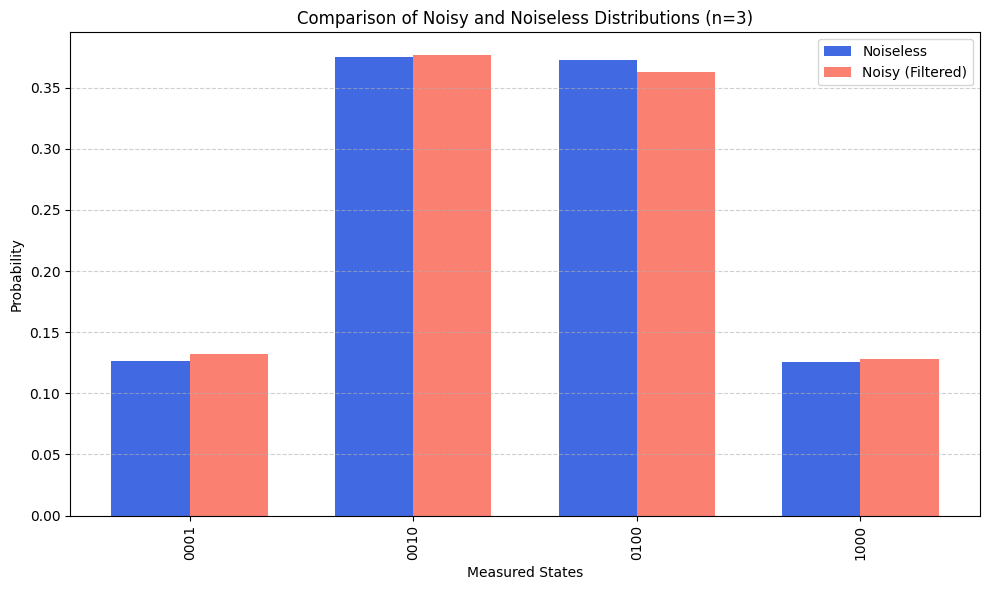

Total Variation Distance (TVD): 0.0094
Kullback-Leibler Divergence (KL): 0.0003


In [35]:
# Compare distributions after filtering
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)


## Optimizing the transpiled circuit to achieve better closeness

### Post-Transpilation Error Analysis



In [36]:
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:

    backend= AerSimulator.from_backend(noisy_fake_backend)  # Using the noisy simulator for ibm_torino
    circuit_transpiled = transpile(qc, backend, optimization_level=3)
    qubit_layout = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 

    error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_transpiled, n)
    errors_and_counts = [
        error_analysis['errors']['total'],
        error_analysis['errors']['two_qubit'], 
        error_analysis['errors']['single_qubit'],
        error_analysis['errors']['readout'],
        error_analysis['gate_counts']['single_qubit'],
        error_analysis['gate_counts']['two_qubit']
    ]
    errors_and_counts_list.append(errors_and_counts)


for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 170 gates: 0.744
Accumulated one-qubit error of 888 gates: 0.057
Accumulated readout error: 0.099
Accumulated total error: 0.900

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 170 gates: 0.390
Accumulated one-qubit error of 565 gates: 0.085
Accumulated readout error: 0.112
Accumulated total error: 0.587



#### Backend Comparison: IBM Torino shows superior gate fidelity and it has the least total error. Hence we use this for further optimization. 

#### Let's try to map the logical qubits to physical qubits with a goal of reducing the two qubit gate error.

The function `finding_best_seed` searches through 500 different transpiler seeds using the SABRE layout method to find the optimal qubit mapping that minimizes two-qubit gate errors for a given quantum circuit and backend.

**Note:** SABRE (SWAP-based Bidirectional heuristic for Routing) is an advanced qubit routing algorithm that efficiently maps logical qubits to physical qubits by minimizing the number of SWAP gates needed to satisfy hardware connectivity constraints.

In [37]:
def finding_best_seed(
    circuit: QuantumCircuit, backend, n: int, layout: str, seed_transpiler: int
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    best_seed_transpiler = 0
    
    for seed_transpiler in range(0, seed_transpiler):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method= layout,  # dense layout gave a higher error than sabre
        )

        circuit_opt_seed = pm.run([circuit])[0]
        
        error_analysis = circuit_error_analysis(backend, circuit_opt_seed, n)
        acc_two_qubit_error_seed_loop = error_analysis['errors']['two_qubit']
        two_qubit_gate_count_seed_loop = error_analysis['gate_counts']['two_qubit']
        
        if acc_two_qubit_error_seed_loop < min_err_acc_seed_loop:
            min_err_acc_seed_loop = acc_two_qubit_error_seed_loop
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )

(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qc, noisy_fake_backends[1], n, "sabre", 500)  

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:2*n+1]
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first 2n+1 logical qubits mapped to physical qubits):\n {best_layout}")


error_analysis = circuit_error_analysis(noisy_fake_backends[1], circuit_opt_seed_loop, n)
print(f"Accumulated single-qubit error: {error_analysis['errors']['single_qubit']:.3f}")
print(f"Accumulated readout error: {error_analysis['errors']['readout']:.3f}")
print(f"Accumulated total error: {error_analysis['errors']['total']:.3f}")
print(f"Single-qubit gate count: {error_analysis['gate_counts']['single_qubit']}")

Minimum accumulated two-qubit gate error: 0.320
Two-qubit gate count for best seed: 169
Best layout (first 2n+1 logical qubits mapped to physical qubits):
 [65, 68, 74, 67, 66, 64, 55]
Accumulated single-qubit error: 0.081
Accumulated readout error: 0.150
Accumulated total error: 0.552
Single-qubit gate count: 568


**Through optimal logical-to-physical qubit mapping, we achieved a significant reduction in accumulated two-qubit gate error from 39% to 32% for the n=3 QGB implementation on IBM Torino. Even the total error slightly decreased to 55.2% from 58.7%.**


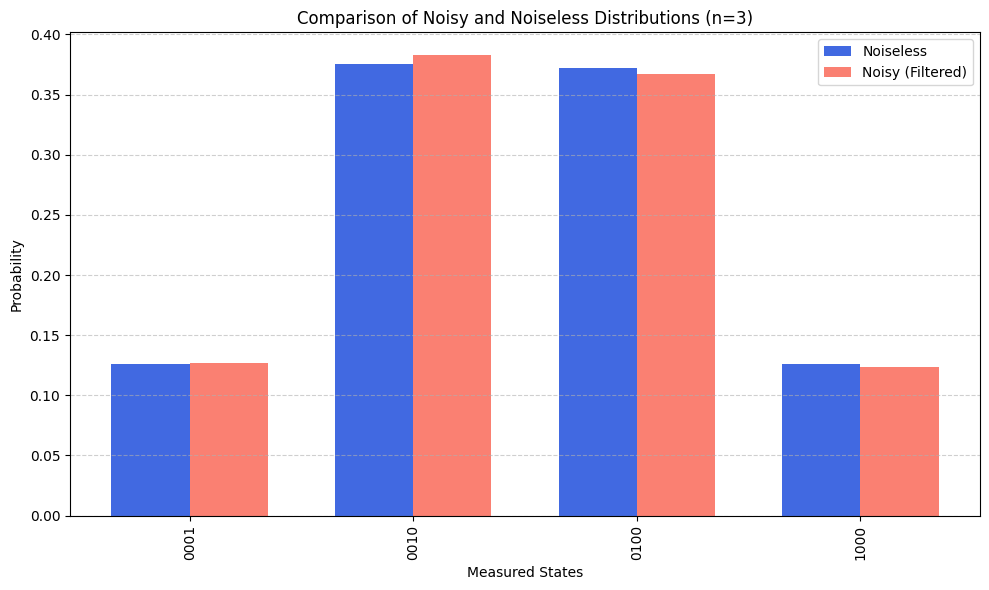

Total Variation Distance (TVD): 0.0075
Kullback-Leibler Divergence (KL): 0.0001


In [38]:
# Run optimized noisy simulation
job = backend.run(circuit_opt_seed_loop, shots=100000) 
noisy_counts = job.result().get_counts()

compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)


#### The optimized layout yields more favourable samples than compared to the case with no optimization. This is clearly evident from the improved values of the distance mesaures - for example the KL divergence has reduced by $50\%$ indicating increased closeness of the two distributions. 

**Note: This specific pass manager settings cannot be a general strategy for any number of layers. One has to carefully work with finding the optimal layout for different circuit sizes as different physical qubits have very different characteristics.**

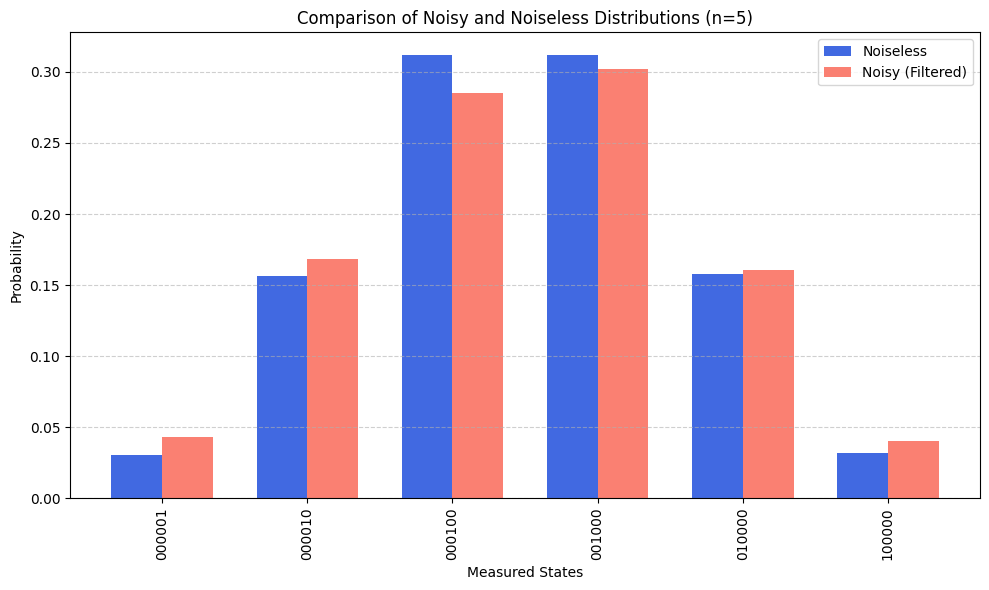

Total Variation Distance (TVD): 0.0366
Kullback-Leibler Divergence (KL): 0.0051


In [39]:
n=5 # number of levels in the Galton board
qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)


# Run noisy simulation 
job = backend.run(qc_transpiled, shots=100000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()


# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=100000) 
noiseless_counts = job.result().get_counts()


# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)


#### Based on our simulation, after the post processing (keeping only the samples with Hamming weight=$1$) the resulting noisy normal distribution very closely resembles the noiseless normal distribution characteristics. 

## Complexity Analysis

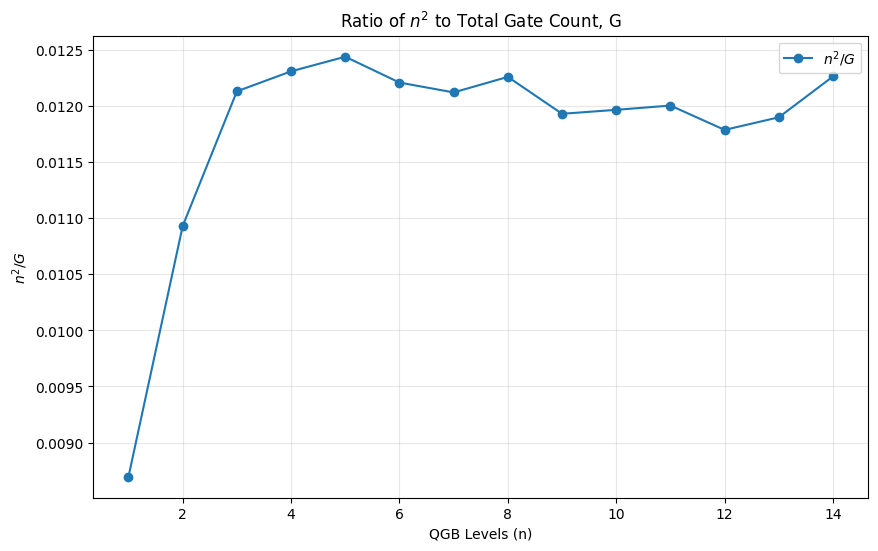

In [40]:
N = []
total_gates = []
for n in range(1, 15):
    qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
    backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
    compiled = transpile(qc, backend, optimization_level=3)
    total_gate = sum(compiled.count_ops().values())
    N.append(n)
    total_gates.append(total_gate)

N_array = np.array(N)
total_gates_array = np.array(total_gates)

# Calculate the ratio n^2 / Total Gate Count
ratio_n2_gates = (N_array ** 2) / total_gates_array


fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('QGB Levels (n)')
ax.set_ylabel(r'$n^2 / G$')
ax.plot(N, ratio_n2_gates, 'o-', label=r'$n^2 / G$')
ax.set_title(r'Ratio of $n^2$ to Total Gate Count, G')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

Polynomial fits in log₂(n):
Circuit Depth ≈ 183.46(log₂(n))⁴ + -942.37(log₂(n))³ + 1857.64(log₂(n))² + -1013.94(log₂(n)) + 90.64
Circuit Depth R² = 0.9990

Total Gates ≈ 282.80(log₂(n))⁴ + -1372.33(log₂(n))³ + 2578.45(log₂(n))² + -1313.73(log₂(n)) + 123.46
Total Gates R² = 0.9998


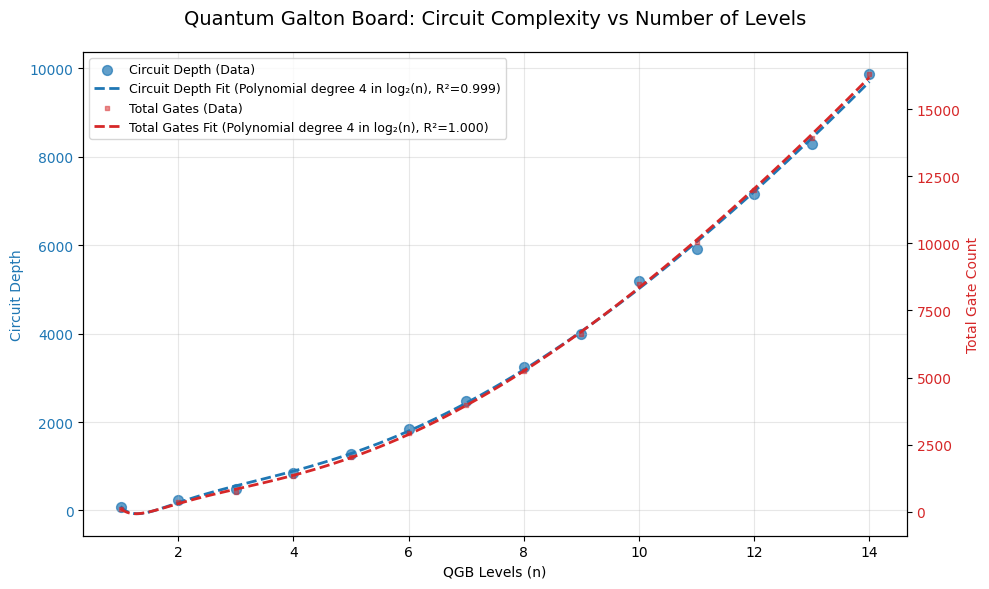

In [41]:
N = []
circuit_depths = []
total_gates = []
for n in range(1, 15):
    qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
    backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
    compiled = transpile(qc, backend, optimization_level=3)
    circuit_depth = compiled.depth()
    total_gate = sum(compiled.count_ops().values())
    N.append(n)
    circuit_depths.append(circuit_depth)
    total_gates.append(total_gate)

N_array = np.array(N)
log_N = np.log2(N_array)
circuit_depths_array = np.array(circuit_depths)
total_gates_array = np.array(total_gates)

# Polynomial fitting (degree 4) in log2(n)
poly_degree = 4
depth_coeffs = np.polyfit(log_N, circuit_depths_array, poly_degree)
gates_coeffs = np.polyfit(log_N, total_gates_array, poly_degree)


def calculate_r_squared(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate fitted values for R² computation
depth_fitted = np.polyval(depth_coeffs, log_N)
gates_fitted = np.polyval(gates_coeffs, log_N)

# Calculate R² values
depth_r2 = calculate_r_squared(circuit_depths_array, depth_fitted)
gates_r2 = calculate_r_squared(total_gates_array, gates_fitted)

# Generate smooth curves for plotting
log_N_smooth = np.linspace(log_N.min(), log_N.max(), 100)
N_smooth = 2**log_N_smooth
depth_fit = np.polyval(depth_coeffs, log_N_smooth)
gates_fit = np.polyval(gates_coeffs, log_N_smooth)


fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'tab:blue'
ax1.set_xlabel('QGB Levels (n)')
ax1.set_ylabel('Circuit Depth', color=color1)
ax1.scatter(N, circuit_depths, color=color1, s=50, alpha=0.7, label='Circuit Depth (Data)')
ax1.plot(N_smooth, depth_fit, color=color1, linewidth=2, linestyle='--', 
         label=f'Circuit Depth Fit (Polynomial degree {poly_degree} in log₂(n), R²={depth_r2:.3f})')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Total Gate Count', color=color2)
ax2.scatter(N, total_gates, color=color2, s=10, marker='s', alpha=0.5, label='Total Gates (Data)')
ax2.plot(N_smooth, gates_fit, color=color2, linewidth=2, linestyle='--', 
         label=f'Total Gates Fit (Polynomial degree {poly_degree} in log₂(n), R²={gates_r2:.3f})')
ax2.tick_params(axis='y', labelcolor=color2)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
plt.title('Quantum Galton Board: Circuit Complexity vs Number of Levels', 
          fontsize=14, pad=20)
plt.tight_layout()

print("Polynomial fits in log₂(n):")
print(f"Circuit Depth ≈ {depth_coeffs[0]:.2f}(log₂(n))⁴ + {depth_coeffs[1]:.2f}(log₂(n))³ + {depth_coeffs[2]:.2f}(log₂(n))² + {depth_coeffs[3]:.2f}(log₂(n)) + {depth_coeffs[4]:.2f}")
print(f"Circuit Depth R² = {depth_r2:.4f}")
print(f"\nTotal Gates ≈ {gates_coeffs[0]:.2f}(log₂(n))⁴ + {gates_coeffs[1]:.2f}(log₂(n))³ + {gates_coeffs[2]:.2f}(log₂(n))² + {gates_coeffs[3]:.2f}(log₂(n)) + {gates_coeffs[4]:.2f}")
print(f"Total Gates R² = {gates_r2:.4f}")

plt.show()



##### The empirical analysis demonstrates that as $n$ increases, the ratio $n^2/G$ stabilizes, confirming that the total gate count $G$ for the generalized noisy Galton board scales quadratically with the number of levels, i.e., $G \in O(n^2)$.
##### **Infact, G is also a polynomial function of $log_2(N)$ which suggests much better scaling of the generalized noisy transpiled circuit than $O(n^2)$**

___
___

## Noisy simulation for exponential distribution

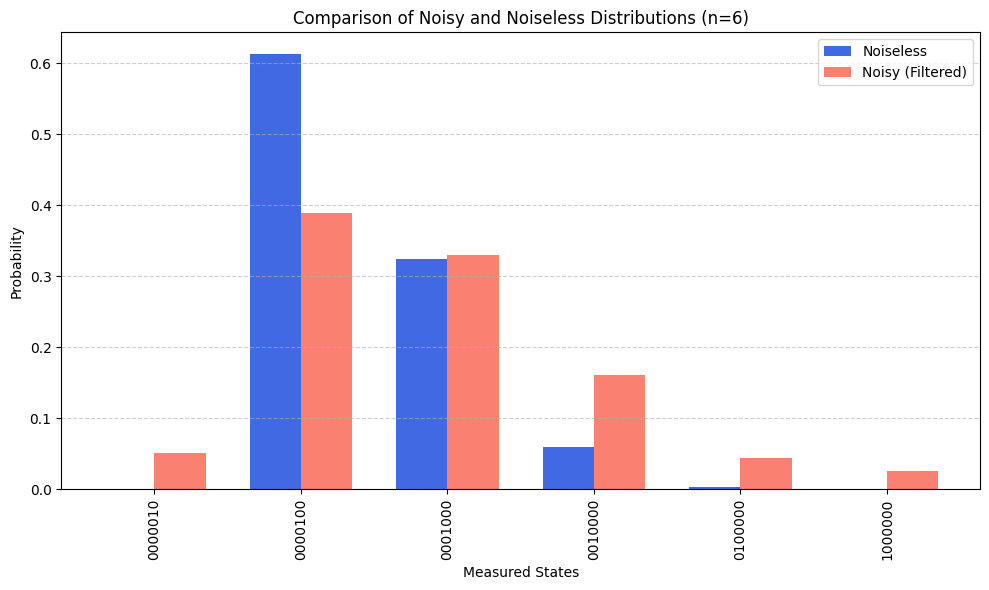

Total Variation Distance (TVD): 0.2234
Kullback-Leibler Divergence (KL): 0.0956


In [42]:
n=6

qc = Generalized_Galton_Board.galton_box_shifted(n, Generalized_Galton_Board.row_dependent_gate_right)
backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)

# Run noisy simulation
job = backend.run(qc_transpiled, shots=10000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()

# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=10000)  # Using same shot count for fair comparison
noiseless_counts = job.result().get_counts()

# Filter the counts dictionaries in-place 
# # since we know from theoretical analysis that the first and last two bitstrings don't contribute to the distribution
def filter_counts_inplace(counts: dict, remove_count: int = 2):
    """Filter counts dictionary in-place by removing edge bitstrings."""
    if len(counts) <= 2 * remove_count:
        counts.clear()
        return
    
    sorted_bitstrings = sorted(counts.keys())
    bitstrings_to_remove = sorted_bitstrings[:remove_count] + sorted_bitstrings[-remove_count+1:]
    
    for bitstring in bitstrings_to_remove:
        counts.pop(bitstring, None)

filter_counts_inplace(noisy_counts, remove_count=2)


# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)

In [ ]:
def filter_counts_inplace(counts: dict, remove_count: int = 2):
    """Filter counts dictionary in-place by removing edge bitstrings."""
    if len(counts) <= 2 * remove_count:
        counts.clear()
        return
    
    sorted_bitstrings = sorted(counts.keys())
    bitstrings_to_remove = sorted_bitstrings[:remove_count] + sorted_bitstrings[-remove_count+1:]
    
    for bitstring in bitstrings_to_remove:
        counts.pop(bitstring, None)

filter_counts_inplace(noisy_counts, remove_count=2)


# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)

___
___

#### Working with the AI pass manager (TODO)

In [27]:
# def finding_best_seed(
#     circuit: QuantumCircuit, backend, n: int, layout: str, seed_transpiler: int
# ) -> tuple[QuantumCircuit, int, float, int]:
#     """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

#     # We initialize the minimum error accumulated
#     min_err_acc_seed_loop = 100
#     circuit_opt_best_seed = None
#     best_seed_transpiler = 0
    
#     for seed_transpiler in range(0, seed_transpiler):
#         pm = generate_preset_pass_manager(
#             backend=backend,
#             optimization_level=3,
#             seed_transpiler=seed_transpiler,
#             layout_method= layout,  # dense layout gave a higher error than sabre
#         )

#         circuit_opt_seed = pm.run([circuit])[0]
        
#         error_analysis = circuit_error_analysis(backend, circuit_opt_seed, n)
#         acc_two_qubit_error_seed_loop = error_analysis['errors']['two_qubit']
#         two_qubit_gate_count_seed_loop = error_analysis['gate_counts']['two_qubit']
        
#         if acc_two_qubit_error_seed_loop < min_err_acc_seed_loop:
#             min_err_acc_seed_loop = acc_two_qubit_error_seed_loop
#             circuit_opt_best_seed = circuit_opt_seed
#             best_seed_transpiler = seed_transpiler

#     return (
#         circuit_opt_best_seed,
#         best_seed_transpiler,
#         min_err_acc_seed_loop,
#         two_qubit_gate_count_seed_loop,
#     )



# (
#     circuit_opt_seed_loop,
#     best_seed_transpiler,
#     min_err_acc_seed_loop,
#     two_qubit_gate_count_seed_loop,
# ) = finding_best_seed(qc, noisy_fake_backends[1], n, "sabre", 500)  

# best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:2*n+1]
# print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
# print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
# print(f"Best layout (first 2n+1 logical qubits mapped to physical qubits):\n {best_layout}")


# error_analysis = circuit_error_analysis(noisy_fake_backends[1], circuit_opt_seed_loop, n)
# print(f"Accumulated single-qubit error: {error_analysis['errors']['single_qubit']:.3f}")
# print(f"Accumulated readout error: {error_analysis['errors']['readout']:.3f}")
# print(f"Accumulated total error: {error_analysis['errors']['total']:.3f}")
# print(f"Single-qubit gate count: {error_analysis['gate_counts']['single_qubit']}")

In [28]:
# gaussian_transpiled_list = []
# errors_and_counts_list = []
# for noisy_fake_backend in noisy_fake_backends:

#     backend= AerSimulator.from_backend(noisy_fake_backend)  # Using the noisy simulator for ibm_torino
#     circuit_transpiled = transpile(qc, backend, optimization_level=3)
#     qubit_layout = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 
#     print(f"Qubit layout: {qubit_layout}")

#     print('Gates used on the noisy simulator:', circuit_transpiled.count_ops())

#     gaussian_transpiled_list.append(circuit_transpiled)

#     error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_transpiled, n)
#     errors_and_counts = [
#         error_analysis['errors']['total'],
#         error_analysis['errors']['two_qubit'], 
#         error_analysis['errors']['single_qubit'],
#         error_analysis['errors']['readout'],
#         error_analysis['gate_counts']['single_qubit'],
#         error_analysis['gate_counts']['two_qubit']
#     ]
#     errors_and_counts_list.append(errors_and_counts)


# for backend, (
#     acc_total_error,
#     acc_two_qubit_error,
#     acc_single_qubit_error,
#     acc_readout_error,
#     single_qubit_gate_count,
#     two_qubit_gate_count,
# ) in zip(noisy_fake_backends, errors_and_counts_list):
#     print(f"Backend {backend.name}")
#     print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
#     print(
#         f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
#     )
#     print(f"Accumulated readout error: {acc_readout_error:.3f}")
#     print(f"Accumulated total error: {acc_total_error:.3f}\n")


# (
#     circuit_opt_seed_loop,
#     best_seed_transpiler,
#     min_err_acc_seed_loop,
#     two_qubit_gate_count_seed_loop,
# ) = finding_best_seed(qc, noisy_fake_backends[1], n, "trivial", 500)  

# best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:2*n+1]
# print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
# print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
# print(f"Best layout (first 2n+1 logical qubits mapped to physical qubits):\n {best_layout}")


# error_analysis = circuit_error_analysis(noisy_fake_backends[1], circuit_opt_seed_loop, n)
# print(f"Accumulated single-qubit error: {error_analysis['errors']['single_qubit']:.3f}")
# print(f"Accumulated readout error: {error_analysis['errors']['readout']:.3f}")
# print(f"Accumulated total error: {error_analysis['errors']['total']:.3f}")
# print(f"Single-qubit gate count: {error_analysis['gate_counts']['single_qubit']}")